In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import labelme
import base64
import io
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
# Root directory of the project
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import json
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
print(MODEL_DIR, COCO_MODEL_PATH)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # 按照PCI_BUS_ID顺序从0开始排列GPU设备
os.environ["CUDA_VISIBLE_DEVICES"]= '0'  # 使用0号gpu（想使用其他编号GPU，对应修改引号中的内容即可）

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

# 忽略warning
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'
import warnings 
warnings.filterwarnings('ignore')

[WARNING] deprecation:<module>:40 - Deprecation warnings have been disabled. Set TF_ENABLE_DEPRECATION_WARNINGS=1 to re-enable them.


Using TensorFlow backend.


1.15.4
['/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core/python/keras/api/_v1', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/api/_v1', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core/_api/v1']
/home/wangjy/research/maskrcnn/logs /home/wangjy/research/maskrcnn/mask_rcnn_coco.h5


In [2]:

# train config
class FacesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "faces"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    # XXX注意: self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet50'


config = FacesConfig()

config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:

# dataset
class FacesDataset(utils.Dataset):
    def __init__(self, dataset_type='train'):
        super(FacesDataset, self).__init__()

        self.DATA_ROOT_DIR = './facedata'

        # Add classes
        self.add_class("faces", 1, "opencomedo")
        self.add_class("faces", 2, "closedcomedo")
        self.add_class("faces", 3, "papule")
        self.add_class("faces", 4, "nudule")
        self.add_class("faces", 5, "scar")
        self.add_class("faces", 6, "undefined")

        all_label_path_list = os.listdir(self.DATA_ROOT_DIR)
        data_len = len(all_label_path_list)

        if dataset_type=='train':
            label_path_list = all_label_path_list[:int(0.8*data_len)]
#             label_path_list = all_label_path_list[0:2]
        elif  dataset_type=='val':
            label_path_list = all_label_path_list[int(0.8*data_len):]
#             label_path_list = all_label_path_list[2:3]
        else:
            raise NotImplementedError

        # 将所有信息放到Image info 中
        sh = 1024
        sw = 1024
        for i, label_path in enumerate(label_path_list):
            # XXX:按1024截取图像
            if not label_path.endswith('.json'):
                continue
            with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
                labelmeJson = json.load(json_file)
                height = labelmeJson['imageHeight'] - sh
                width = labelmeJson['imageWidth'] - sw
                # XXX:按每幅图取10个
                j = 0
                while j < 10:
                    xx = random.randint(0, height - 1)
                    yy = random.randint(0, width - 1)
                    # XXX:进行判断，否则可能会有大量没有mask的图像
                    vaild_cnt = 0
                    for i, shape in enumerate(labelmeJson['shapes']):
                        if shape['shape_type'] == "polygon":
                            # point为h, w
                            inPoints = [k for k, p in enumerate(shape['points']) if p[0]>xx and p[0]<xx+sh and p[1]>yy and p[1]<yy+sw]
                            if len(inPoints) == 0:
                                continue
                            vaild_cnt = vaild_cnt + 1
                        elif shape['shape_type'] == "circle":
                            (cx, cy) = shape['points'][0]
                            if cx>xx and cx<xx+sh and cy>yy and cy<yy+sw :
                                vaild_cnt = vaild_cnt + 1
                    if vaild_cnt <= 1:
                        if random.random() < 0.2:
                            self.add_image(source="faces", image_id=i*10+j, path=label_path, crop_coordinate = (xx, yy), crop_size=(1024, 1024))
                            j = j + 1
                    else:
                        self.add_image(source="faces", image_id=i*10+j, path=label_path, crop_coordinate = (xx, yy), crop_size=(1024, 1024))
                        j = j + 1
        

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        label_path = info['path']
        xx = info['crop_coordinate'][0]
        yy = info['crop_coordinate'][1]
        sh = info['crop_size'][0]
        sw = info['crop_size'][1]
        # 读取json文件
        with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
            labelmeJson = json.load(json_file)
            # height = labelmeJson['imageHeight']
            # width = labelmeJson['imageWidth']
            # shape_list = labelmeJson['shapes']
            image = self.img_b64_to_arr(labelmeJson['imageData'])
            image = image[xx:xx+sh, yy:yy+sw, :]
            return image

    def img_b64_to_arr(self, img_b64):
        img_data = base64.b64decode(img_b64)
        f = io.BytesIO()
        f.write(img_data)
        img_pil = PIL.Image.open(f)
        img_arr = np.asarray(img_pil)
        return img_arr

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "faces":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def shape_to_mask(self, img_shape, points, shape_type=None, line_width=10, point_size=5):
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        mask = PIL.Image.fromarray(mask)
        draw = PIL.ImageDraw.Draw(mask)
        xy = [tuple(point) for point in points]
        if shape_type == "circle":
            assert len(xy) == 2, "Shape of shape_type=circle must have 2 points"
            (cx, cy), (px, py) = xy
            d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
            draw.ellipse([cx - d, cy - d, cx + d, cy + d], outline=1, fill=1)
        elif shape_type == "rectangle":
            assert len(xy) == 2, "Shape of shape_type=rectangle must have 2 points"
            draw.rectangle(xy, outline=1, fill=1)
        elif shape_type == "line":
            assert len(xy) == 2, "Shape of shape_type=line must have 2 points"
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == "linestrip":
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == "point":
            assert len(xy) == 1, "Shape of shape_type=point must have 1 points"
            cx, cy = xy[0]
            r = point_size
            draw.ellipse([cx - r, cy - r, cx + r, cy + r], outline=1, fill=1)
        else:
            assert len(xy) > 2, "Polygon must have points more than 2"
            draw.polygon(xy=xy, outline=1, fill=1)
        mask = np.array(mask, dtype=bool)
        return mask

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        label_path = info['path']
        xx = info['crop_coordinate'][0]
        yy = info['crop_coordinate'][1]
        sh = info['crop_size'][0]
        sw = info['crop_size'][1]

        # 读取json文件
        with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
            labelmeJson = json.load(json_file)
            height = labelmeJson['imageHeight']
            width = labelmeJson['imageWidth']
            shapes = labelmeJson['shapes']

            croped_points = []
            croped_shape_type = []
            croped_label = []
            for i, shape in enumerate(shapes):
                if shape['shape_type'] == "polygon":
                    # point为h, w
                    inPoints = [k for k, p in enumerate(shape['points']) if p[0]>xx and p[0]<xx+sh and p[1]>yy and p[1]<yy+sw]
                    if len(inPoints) == 0:
                        continue
                    croped_points.append(shape['points'])
                    croped_shape_type.append(shape['shape_type'])
                    croped_label.append(shape['label'])
                elif shape['shape_type'] == "circle":
                    (cx, cy) = shape['points'][0]
                    if cx>xx and cx<xx+sh and cy>yy and cy<yy+sw :
                        croped_points.append(shape['points'])
                        croped_shape_type.append(shape['shape_type'])
                        croped_label.append(shape['label'])
            
            count = len(croped_points)
            mask = np.zeros([sh, sw, count], dtype=np.uint8)

            for i, points in enumerate(croped_points):
                mask_item = self.shape_to_mask((height, width), points, croped_shape_type[i])
                mask[:, :, i] = mask_item[xx:xx+sh, yy:yy+sw]

            # Map class names to class IDs.
            class_ids = np.array([self.class_names.index(label) if label in self.class_names else self.class_names.index('undefined') for label in croped_label])
            #print('class_ids:', class_ids)
            #input()
            return mask.astype(np.bool), class_ids.astype(np.int32)


print('prepare finish')

# Training dataset
dataset_train = FacesDataset('train')
dataset_train.prepare()

# Validation dataset
dataset_val = FacesDataset('val')
dataset_val.prepare()

print('prepared ',len(dataset_train.image_ids),' croped images')

prepare finish
prepared  810  croped images


In [5]:
class InferenceConfig(FacesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




Loading weights from  /home/wangjy/research/maskrcnn/logs/faces20210130T1010/mask_rcnn_faces_0080.h5


[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




Re-starting from epoch 80


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (2,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:  200.00000  max:  650.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


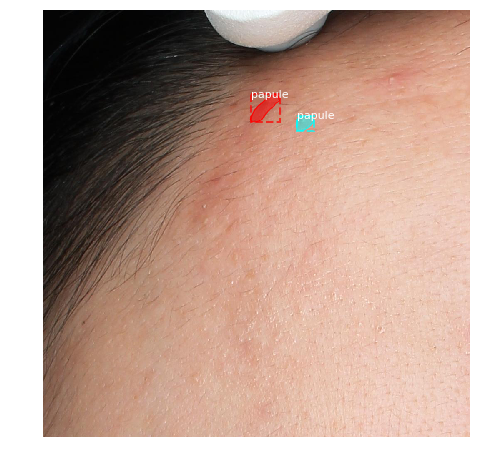

In [6]:

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [7]:
# results = model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    print(AP,' ',end = '')
    
print("mAP: ", np.mean(APs))

nan  0.0  0.0  nan  nan  0.0  nan  0.0  nan  0.0  mAP:  nan


In [8]:

# image_ids = np.random.choice(dataset_val.image_ids, 10)
dataset_list = [dataset_train, dataset_val] # dataset_train, dataset_val
for dataset in dataset_list:
    gt_list = []
    r_list = []
    #image_ids = np.random.choice(dataset.image_ids, 200)
    image_ids = dataset.image_ids
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                   image_id, use_mini_mask=False)
        gt_list.append({'gt_bbox': gt_bbox, 'gt_class_id': gt_class_id, 'gt_mask': gt_mask})
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        r_list.append(r)
    
    # Compute AP
    AP, precision, recall, overlap = utils.compute_ap_Wei(gt_list, r_list)
    
    print('mAP = %-8.4f precision = %-8.4f recall = %-8.4f' % (AP, precision[-2], recall[-2]))

mAP = 0.0150   precision = 0.1082   recall = 0.0620  
mAP = 0.0109   precision = 0.0995   recall = 0.0727  


In [ ]:
DATA_ROOT_DIR = './facedata'

all_label_path_list = os.listdir(DATA_ROOT_DIR)
data_len = len(all_label_path_list)

whole_image_name = np.random.choice(all_label_path_list, 1)

whole_image_name = whole_image_name[0]
sh = 1024
sw = 1024
with open(os.path.join(DATA_ROOT_DIR, whole_image_name), encoding='utf-8') as json_file:
    labelmeJson = json.load(json_file)
    height = labelmeJson['imageHeight']
    width = labelmeJson['imageWidth']
    def img_b64_to_arr(img_b64):
        img_data = base64.b64decode(img_b64)
        f = io.BytesIO()
        f.write(img_data)
        img_pil = PIL.Image.open(f)
        img_arr = np.asarray(img_pil)
        return img_arr
    image = img_b64_to_arr(labelmeJson['imageData'])
    
    pred_boxes_all = np.empty(shape=(0,4))
    pred_class_ids_all = np.empty(shape=(), dtype=np.int16)
    pred_scores_all = np.empty(shape=(), dtype=np.int16)
    pred_masks_all = np.empty(shape=(height,width,0), dtype=np.bool)
    # XXX:因为32是box的最大值
    for i in range(0, height, sh - 32):
        for j in range(0, width, sw - 32):
            sub_image = image[i:i+sh, j:j+sw, :]
            results = model.detect([sub_image], verbose=0)
            r_list = results[0]
            
            pred_boxes = r_list['rois']
            pred_class_ids = r_list['class_ids']
            pred_scores = r_list['scores']
            pred_masks = r_list['masks']
            
            if len(pred_class_ids) == 0:
                continue
            pred_boxes = [(y1+i, x1+j, y2+i, x2+j) for (y1, x1, y2, x2) in pred_boxes]
            sub_mask = np.zeros([height, width, len(pred_class_ids)], dtype=np.bool)
            sub_mask[i:i+sh, j:j+sw, :] = pred_masks
            
            pred_boxes_all = np.concatenate([pred_boxes_all, pred_boxes], 0)
            pred_class_ids_all = np.append(pred_class_ids_all, pred_class_ids) 
            pred_scores_all = np.append(pred_scores_all, pred_scores)
            pred_masks_all = np.concatenate([pred_masks_all, sub_mask], 2)
    
    pred_class_ids_all = np.delete(pred_class_ids_all, [0])
    pred_scores_all = np.delete(pred_scores_all, [0])
    visualize.display_instances(image, pred_boxes_all, pred_masks_all, pred_class_ids_all, 
                            dataset_val.class_names, pred_scores_all, ax=get_ax())

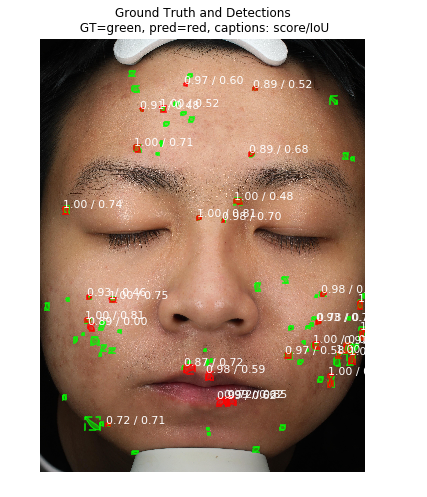

In [7]:
import labelme.utils as lu

def originDataLoader(image_path, class_names):
    with open(image_path, encoding='utf-8') as json_file:
        labelmeJson = json.load(json_file)
        height = labelmeJson['imageHeight']
        width = labelmeJson['imageWidth']
        
        image = lu.img_b64_to_arr(labelmeJson['imageData'])
        image = image.astype(np.uint8)

        shapes = labelmeJson['shapes']
        mask = np.zeros([height, width, len(shapes)], dtype=np.uint8)
        for i, shape in enumerate(shapes):
            mask[:,:,i] = lu.shape_to_mask([height, width], shape['points'], shape['shape_type'])
            
        class_ids = np.array([class_names.index(s['label']) for s in shapes])
        return image, mask.astype(np.bool), class_ids.astype(np.int32)


DATA_ROOT_DIR = './facedata'

all_label_path_list = os.listdir(DATA_ROOT_DIR)
data_len = len(all_label_path_list)

whole_image_name = np.random.choice(all_label_path_list, 1)

whole_image_name = whole_image_name[0]
print("chose image: ",whole_image_name)
sh = 1024
sw = 1024
with open(os.path.join(DATA_ROOT_DIR, whole_image_name), encoding='utf-8') as json_file:
    labelmeJson = json.load(json_file)
    height = labelmeJson['imageHeight']
    width = labelmeJson['imageWidth']
    def img_b64_to_arr(img_b64):
        img_data = base64.b64decode(img_b64)
        f = io.BytesIO()
        f.write(img_data)
        img_pil = PIL.Image.open(f)
        img_arr = np.asarray(img_pil)
        return img_arr
    image = img_b64_to_arr(labelmeJson['imageData'])
    
    _, gt_mask, gt_class_id = originDataLoader(os.path.join(DATA_ROOT_DIR, whole_image_name), dataset_val.class_names)
    gt_box = utils.extract_bboxes(gt_mask)
    
    pred_boxes_all = np.empty(shape=(0,4))
    pred_class_ids_all = np.empty(shape=(), dtype=np.int16)
    pred_scores_all = np.empty(shape=(), dtype=np.int16)
    pred_masks_all = np.empty(shape=(height,width,0), dtype=np.bool)
    # XXX:因为32是box的最大值
    for i in range(0, height, sh - 32):
        for j in range(0, width, sw - 32):
            sub_image = image[i:i+sh, j:j+sw, :]
            results = model.detect([sub_image], verbose=0)
            r_list = results[0]
            
            pred_boxes = r_list['rois']
            pred_class_ids = r_list['class_ids']
            pred_scores = r_list['scores']
            pred_masks = r_list['masks']
            
            if len(pred_class_ids) == 0:
                continue
            pred_boxes = [(y1+i, x1+j, y2+i, x2+j) for (y1, x1, y2, x2) in pred_boxes]
            sub_mask = np.zeros([height, width, len(pred_class_ids)], dtype=np.bool)
            sub_mask[i:i+sh, j:j+sw, :] = pred_masks
            
            pred_boxes_all = np.concatenate([pred_boxes_all, pred_boxes], 0)
            pred_class_ids_all = np.append(pred_class_ids_all, pred_class_ids) 
            pred_scores_all = np.append(pred_scores_all, pred_scores)
            pred_masks_all = np.concatenate([pred_masks_all, sub_mask], 2)
    
    pred_class_ids_all = np.delete(pred_class_ids_all, [0])
    pred_scores_all = np.delete(pred_scores_all, [0])
    # visualize.display_instances(image, pred_boxes_all, pred_masks_all, pred_class_ids_all, 
    #                         dataset_val.class_names, pred_scores_all, ax=get_ax())
    visualize.display_differences(image, gt_box, gt_class_id, gt_mask,
                            pred_boxes_all, pred_class_ids_all, pred_scores_all, pred_masks_all, dataset_val.class_names, ax=get_ax())